# **DCGAN Unlearning**

Requires:
- Original model.
- Negatively adapted model.
- Positive samples (obtained from feedback).

## **Imports**

In [1]:
import os
import time
import random
from tqdm import tqdm
import numpy as np

import argparse

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from scipy.linalg import sqrtm
from sklearn.manifold import TSNE

import networks as nws
import utils

In [2]:
# Thiết bị sử dụng
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [3]:
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

## **Models**

In [4]:
nz = 128

version = 3
G_final = nws.Generator(version=version, nz=nz).to(device)
D_final = nws.Discriminator(version=version).to(device)
G_adapt = nws.Generator(version=version, nz=nz).to(device)
D_adapt = nws.Discriminator(version=version).to(device)

# Tải trọng số vào mô hình
original_train_epochs = 300
original_save_dir = "checkpoints_original"
adapt_epochs = 250
adapt_weight = 5e8
adapt_save_dir = "checkpoints_adapt"

# adapt_dset = "MNIST_ul1_data"
adapt_dset = "MNIST_ul8_data"

G_final.load_state_dict(torch.load(f'{original_save_dir}/gen_MNIST_full_v{version}_nz={nz}_epochs={original_train_epochs}.pth'))
D_final.load_state_dict(torch.load(f'{original_save_dir}/dis_MNIST_full_v{version}_nz={nz}_epochs={original_train_epochs}.pth'))
G_adapt.load_state_dict(torch.load(f"{adapt_save_dir}/gen_adapted_v{version}_nz={nz}_weight={adapt_weight}_epochs={adapt_epochs}_dataset={adapt_dset}.pth"))
D_adapt.load_state_dict(torch.load(f"{adapt_save_dir}/dis_adapted_v{version}_nz={nz}_weight={0}_epochs={adapt_epochs}_dataset={adapt_dset}.pth"))

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(G_final.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(D_final.parameters(), lr=lr, betas=(beta1, 0.999))

do_mask = True
ckpt_dir_suffix = "_mask" if do_mask else ""

C:\Users\Admin\AppData\Local\Temp\ipykernel_2644\2305928588.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_final.load_state_dict(torch.load(f'{original_save_dir}/gen

## **Saliency masking**

In [5]:
def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def masking(top_ratio, generator, discriminator, num, _criterion, device, outdir="saliency_mask"):
    generator.eval()
    discriminator.eval()
    requires_grad(generator, True)
    requires_grad(discriminator, False)

    save_path = os.path.join(outdir, "mask.pt")

    # Initialize gradient accumulator
    gradients = {
        name: torch.zeros_like(param, device=device)
        for name, param in generator.named_parameters()
        if param.requires_grad
    }

    for _ in tqdm(range(num), desc="Computing gradients for mask"):
        # Fake image generation
        noise = torch.randn(50, nz, 1, 1, device=device)
        fake_img = generator(noise)

        label = torch.full((50,), real_label, dtype=torch.float, device=device)
        fake_pred = discriminator(fake_img).view(-1)
        g_loss = _criterion(fake_pred, label)
        
        generator.zero_grad()
        g_loss.backward()

        # Accumulate gradients
        with torch.no_grad():
            for name, param in generator.named_parameters():
                if param.grad is not None:
                    gradients[name] += param.grad.detach()

    # Take absolute value of gradients (saliency)
    for name in gradients:
        gradients[name] = torch.abs(gradients[name])

    # Build binary saliency mask based on top `top_ratio` elements
    all_elements = -torch.cat([g.flatten() for g in gradients.values()])
    threshold_index = int(len(all_elements) * top_ratio)

    positions = torch.argsort(all_elements) # index: rank, element: ORIGINAL INDEX
    ranks = torch.argsort(positions)        # index: ORIGINAL INDEX, element: rank

    start_index = 0
    mask_dict = {}
    for name, tensor in gradients.items():
        numel = tensor.numel()
        tensor_ranks = ranks[start_index:start_index + numel].reshape(tensor.shape)
        threshold_tensor = torch.zeros_like(tensor_ranks)
        threshold_tensor[tensor_ranks < threshold_index] = 1
        mask_dict[name] = threshold_tensor
        start_index += numel

    # Save mask
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(mask_dict, save_path)
    print(f" Mask saved to: {save_path}")

In [6]:
mask_dir = f"saliency_mask_{adapt_dset}"
if not os.path.exists(f"{mask_dir}/mask.pt") and do_mask:
    masking(0.5, G_adapt, D_adapt, 100, criterion, device, outdir=f"{mask_dir}")

if do_mask and os.path.exists(f"{mask_dir}/mask.pt"):
    with torch.serialization.safe_globals([argparse.Namespace]):
        mask = torch.load(f"{mask_dir}/mask.pt", map_location=lambda storage, loc: storage, weights_only=True)
else: 
    mask = None

print(mask)

{'model.0.weight': tensor([[[[0, 1, 1, 1],
          [0, 1, 0, 0],
          [0, 1, 1, 0],
          [0, 0, 1, 0]],

         [[0, 1, 1, 0],
          [0, 1, 1, 0],
          [1, 1, 1, 0],
          [1, 1, 1, 0]],

         [[1, 1, 1, 0],
          [0, 0, 0, 1],
          [1, 1, 1, 0],
          [0, 0, 1, 0]],

         ...,

         [[0, 1, 0, 0],
          [0, 1, 1, 1],
          [0, 1, 1, 0],
          [0, 1, 1, 0]],

         [[0, 1, 1, 0],
          [0, 1, 1, 0],
          [1, 1, 0, 0],
          [0, 1, 0, 0]],

         [[1, 1, 1, 0],
          [0, 0, 1, 1],
          [0, 1, 0, 0],
          [0, 0, 1, 0]]],


        [[[0, 1, 0, 0],
          [0, 1, 0, 0],
          [0, 0, 1, 0],
          [0, 1, 1, 0]],

         [[0, 0, 0, 0],
          [1, 0, 0, 0],
          [1, 1, 1, 0],
          [1, 0, 1, 0]],

         [[0, 0, 1, 0],
          [1, 0, 1, 1],
          [1, 1, 1, 0],
          [0, 1, 1, 0]],

         ...,

         [[0, 1, 1, 0],
          [0, 1, 0, 0],
          [0, 1, 0,

## **Save a vector corresponding to `1` or `8` (WARNING: DO NOT TOUCH!!!!)**

don't edit/run because you'll have to find a new vector by eye!!

In [7]:
# # Create a batch (64) of latent vectors that we will use to visualize
# #  the progression of the generator
# fixed_noise = torch.randn(64, nz, 1, 1, device=device)
# print(fixed_noise.shape)

# with torch.no_grad():
#     fake = G_final(fixed_noise).detach().cpu()
# a = vutils.make_grid(fake, padding=2, normalize=True)
# plt.imshow(np.transpose(a,(1, 2, 0)))

In [8]:
# # inspect by eye because i'm stupid
# i = 48
# vector_1 = fixed_noise[i:i+1, :, :, :]

# with torch.no_grad():
#     fake_1 = G_final(vector_1).detach().cpu()

# fake_1 = fake_1[0, 0, :, :]
# plt.imshow(fake_1)

# vector_np = vector_1.cpu().numpy()

# # Save the vector to a text file
# np.savetxt(f"vector_8_nz={nz}.txt", vector_np.flatten())  # Flatten for 1D representation
# print("Vector saved to vector_8.txt")

## **Samples of `1`s or `8`s (hopefully)**

Vector loaded and reshaped: torch.Size([1, 128, 1, 1])


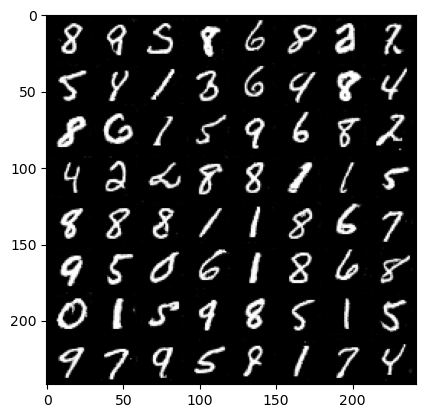

In [9]:
# loaded_vector_np = np.loadtxt(f"vector_1_nz={128}.txt")
loaded_vector_np = np.loadtxt(f"vector_8_nz={128}.txt")

# Reshape it to the original shape of the noise vector
vector_1 = torch.tensor(loaded_vector_np, device=device).view(1, -1, 1, 1)
print("Vector loaded and reshaped:", vector_1.shape)

sigma = 1.7  # Standard deviation for noise

size = [64, vector_1.shape[1], vector_1.shape[2], vector_1.shape[3]]

# Generate random noise tensor around the extracted vector
fixed_noise = vector_1 + torch.normal(mean=0.0, std=sigma, size=size, device=vector_1.device)

with torch.no_grad():
    fake = G_final(fixed_noise.float()).detach().cpu()
imggrid_preunlearn = vutils.make_grid(fake, padding=2, normalize=True)

plt.imshow(np.transpose(imggrid_preunlearn,(1, 2, 0)))
plt.show()

## **Data**

In [10]:
# Root directory for dataset
# dataroot = "MNIST_ul1_data/no1"
dataroot = "MNIST_ul8_data/no8"

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Resize((28, 28)), 
        transforms.Grayscale()
    ])
)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         shuffle=True)

print(len(dataloader))

71


## **Unlearning thingamajic**

In [11]:
def l2_inv(model_N, model, weight=5e8, alpha=None):
    params_N = {n: p for n, p in model_N.named_parameters()}
    params = {n: p for n, p in model.named_parameters()}

    rl = 0
    n_params = 0
    for name in params:
        l2_square = (params[name] - params_N[name])**2
        rl += l2_square.sum()
        n_params += params[name].numel()
    rl /= n_params
    return weight * (1 / rl)


def l2_neg(model_N, model, weight=5e8, alpha=None):
    params_N = {n: p for n, p in model_N.named_parameters()}
    params = {n: p for n, p in model.named_parameters()}

    rl = 0
    n_params = 0
    for name in params:
        l2_square = (params[name] - params_N[name])**2
        rl += l2_square.sum()
        n_params += params[name].numel()
    rl /= n_params
    return weight * (-1 * rl)


def l2_exp(model_N, model, weight=5e8, alpha=0.5):
    params_N = {n: p for n, p in model_N.named_parameters()}
    params = {n: p for n, p in model.named_parameters()}

    rl = 0
    n_params = 0
    for name in params:
        l2_square = (params[name] - params_N[name])**2
        rl += l2_square.sum()
        n_params += params[name].numel()
    rl /= n_params
    return weight * (torch.exp(-alpha * rl))


def l2_ens(model_N, model, weight=5e8, alpha=0.5):
    params_N = {n: p for n, p in model_N.named_parameters()}
    params = {n: p for n, p in model.named_parameters()}

    rl = 0
    n_params = 0
    dot = nu = nv = 0  # For angular
    for name in params:
        l2_square = (params[name] - params_N[name])**2
        rl += l2_square.sum()

        # For angular
        u = params[name].view(-1)
        v = params_N[name].view(-1)
        dot += (u * v).sum()
        nu  += (u * u).sum()
        nv  += (v * v).sum()

        n_params += params[name].numel()
        
    rl /= n_params
    cos = dot / (nu.sqrt() * nv.sqrt() + 1e-8)
    l_ang = F.relu(cos)    # max(0, cos)s
    l_exp = (torch.exp(-alpha * rl))
    return weight * (0.3*l_ang + 0.7*l_exp)

## **Unlearning setup**

Choose a type of repulsion loss:

In [ ]:
# rloss = "l2_inv"
# rloss = "l2_neg"
# rloss = "l2_exp"
rloss = "l2_ens"

Setup hyperparams for the repulsion loss and prepare for unlearning:

In [ ]:
# Decide if you want to save the model or not
# Set to `False` if you want to test and not save
save_model = True

alpha = None
if rloss == "l2_inv":
    repulsion_loss = l2_inv
    rl_weight = 5 # l2_inv
    num_epochs = 5  # l2_inv

elif rloss == "l2_neg":
    repulsion_loss = l2_neg
    rl_weight = 1 # l2_neg 0.1 old
    num_epochs = 300  # l2_neg

elif rloss == "l2_exp":
    repulsion_loss = l2_exp
    rl_weight = 20 # l2_exp 
    alpha = 0.005 # 0.1 0.07 0.05 0.01 0.005
    num_epochs = 300  # l2_exp

elif rloss == "l2_ens":
    repulsion_loss = l2_ens
    rl_weight = 20 # l2_exp 
    alpha = 0.005 # 0.1 0.07 0.05 0.01 0.005
    num_epochs = 300  # l2_exp

c_optimizer = optimizerG.__class__.__name__ # Adam | SGD
# c_lr = str(optimizerD.param_groups[0]['lr']).replace(".", "") # 00002 | 00004 ...

print("-- Epochs: ", num_epochs)
print("-- Current z_dim: ", nz)
print("-- Is training netG: ", G_final.training)
print("-- Is training netD: ", D_final.training)
print("-- Device: ", device)

dataset_name = dataroot.split("/")[0]
save_suffix = f"v{version}_nz={nz}_{rloss}_rlweight={rl_weight}_alpha={alpha}_epochs={num_epochs}_dataset={dataset_name}"
print(dataset_name)

save_dir = f"checkpoints_unlearn{ckpt_dir_suffix}/{rloss}/rlweight={rl_weight}_alpha={alpha}_epochs={num_epochs}_dataset={dataset_name}"
os.makedirs(save_dir, exist_ok=True)

plts_dir = f"plots/GAN_unlearn{ckpt_dir_suffix}_{rloss}"
os.makedirs(plts_dir, exist_ok=True)

-- Epochs:  300
-- Current z_dim:  128
-- Is training netG:  True
-- Is training netD:  True
-- Device:  cuda:0
MNIST_ul8_data


## **Unlearning function**

In [ ]:
%%time

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
real_label = 1.0
fake_label = 0.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, _) in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D_final.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D_final(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # loss_D_repulse = repulsion_loss(D_adapt, D_final, weight=rl_weight, alpha=alpha)
        loss_D_repulse = 0
        loss_D_real = errD_real + loss_D_repulse
        # Calculate gradients for D in backward pass
        loss_D_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G_final(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D_final(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        loss_D_fake = errD_fake
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        loss_D_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + loss_D_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        tG_start = time.time()
        G_final.zero_grad()
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = G_final(noise)
        output = D_final(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        loss_G_repulse = repulsion_loss(G_adapt, G_final, weight=rl_weight, alpha=alpha)
        loss_G = errG + loss_G_repulse
        # Calculate gradients for G
        loss_G.backward()
        D_G_z2 = output.mean().item()
        
        # APPLY MASK IF ANY
        if mask is not None:
            for name, param in G_final.named_parameters():
                if param.grad is not None:
                    param.grad = mask[name].to(device) * param.grad
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(dataloader),
                    errD.item(), loss_G.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G_final(fixed_noise.float()).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        # if (epoch % 25 == 0) and epoch != num_epochs-1 and save_model:
        #     torch.save(G_final.state_dict(), f"{save_dir}/gen_epoch={epoch}_{save_suffix}.pth")

        iters += 1
        torch.cuda.empty_cache()

if save_model:
    torch.save(G_final.state_dict(), f"{save_dir}/gen_unlearned_v{version}_nz={nz}_{rloss}.pth")
    torch.save(D_final.state_dict(), f"{save_dir}/dis_unlearned_v{version}_nz={nz}_{rloss}.pth")

Starting Training Loop...
[1/300][1/71]	Loss_D: 3.7077	Loss_G: 25.8615	D(x): 0.0586	D(G(z)): 0.0051 / 0.0112
[1/300][51/71]	Loss_D: 3.1864	Loss_G: 19.9996	D(x): 0.8460	D(G(z)): 0.8841 / 0.9606
[2/300][1/71]	Loss_D: 1.4105	Loss_G: 20.0428	D(x): 0.4940	D(G(z)): 0.3131 / 0.9270
[2/300][51/71]	Loss_D: 2.1362	Loss_G: 20.4268	D(x): 0.9362	D(G(z)): 0.8185 / 0.6869
[3/300][1/71]	Loss_D: 3.3062	Loss_G: 20.8520	D(x): 0.7787	D(G(z)): 0.9039 / 0.4887
[3/300][51/71]	Loss_D: 4.3858	Loss_G: 20.3102	D(x): 0.9499	D(G(z)): 0.9738 / 0.7389
[4/300][1/71]	Loss_D: 3.4797	Loss_G: 20.1780	D(x): 0.8470	D(G(z)): 0.9369 / 0.8331
[4/300][51/71]	Loss_D: 0.4576	Loss_G: 21.6985	D(x): 0.9100	D(G(z)): 0.2594 / 0.2716
[5/300][1/71]	Loss_D: 0.6744	Loss_G: 20.1566	D(x): 0.9840	D(G(z)): 0.4248 / 0.8367
[5/300][51/71]	Loss_D: 1.1586	Loss_G: 24.6966	D(x): 0.6086	D(G(z)): 0.3352 / 0.0228
[6/300][1/71]	Loss_D: 0.8077	Loss_G: 20.3790	D(x): 0.8851	D(G(z)): 0.4128 / 0.7104
[6/300][51/71]	Loss_D: 0.9325	Loss_G: 21.6082	D(x): 0.73

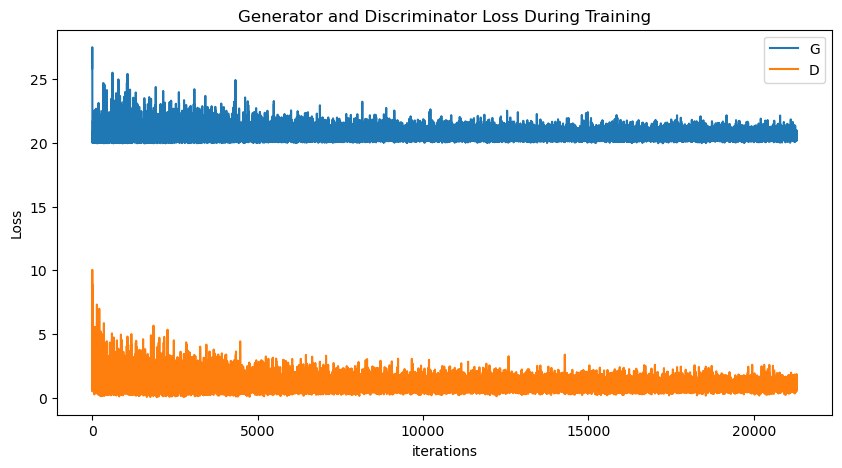

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

figname = f"{plts_dir}/GAN_loss_unlearn_MNIST1_{save_suffix}.jpg"
plt.savefig(figname, bbox_inches="tight")
plt.show()

Create an animated grid of selected samples (take a lot of resource so be mindful):

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.axis("off")

ims = [np.transpose(i,(1,2,0)) for i in img_list]
# img = ax.imshow(ims[0])

# def update(i):
#     if i < 15:
#         img.set_array(ims[0])
#         ax.set_title(f"Unlearning features of digit '1', initial")
#     elif i - 15 >= len(img_list) - 1:
#         img.set_array(ims[-1])
#         ax.set_title(f"Unlearning features of digit '1', final")
#     else:
#         img.set_array(ims[i - 15])
#         ax.set_title(f"Unlearning features of digit '1', iteration: {(i - 15) * 70}")
#     return [img]

# ani = animation.FuncAnimation(
#     fig, update, frames=len(img_list) + 30, interval=100, repeat_delay=1000, blit=True
# )

# # ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)
# ani.save(f"{plts_dir}/unlearnProcess_{rloss}_alpha={alpha}_rlweight={rl_weight}_alpha={alpha}_epochs={num_epochs}.gif")
# HTML(ani.to_jshtml())

In [ ]:
del ani
torch.cuda.empty_cache()

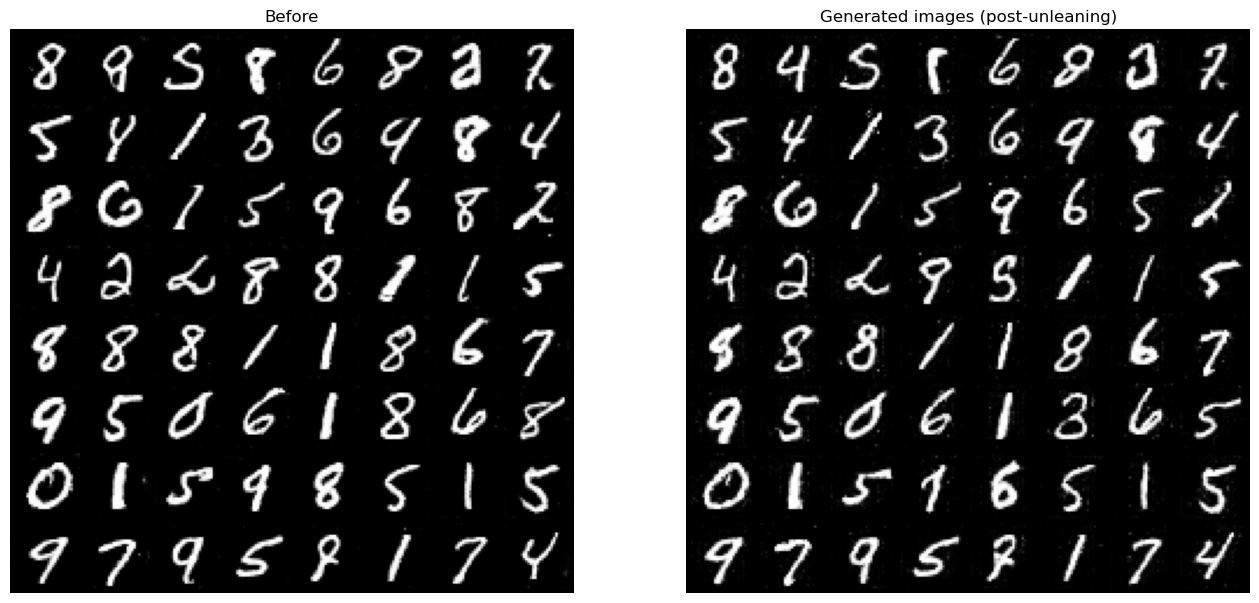

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(np.transpose(imggrid_preunlearn,(1, 2, 0)))
ax[0].set_title("Before")
ax[0].axis("off")
ax[1].imshow(ims[-1])
ax[1].set_title("Generated images (post-unleaning)")
ax[1].axis("off")
figname = f"{plts_dir}/GAN_unlearnCompare_{rloss}_alpha={alpha}_rlweight={rl_weight}_alpha={alpha}_epochs={num_epochs}.jpg"
plt.savefig(figname, bbox_inches="tight")

In [19]:
torch.cuda.empty_cache()
del dataset
del dataloader
del D_final

## **TSNE**

No need to run, but can be useful if you want to test/visualize the results.

In [25]:
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)

# features_original_data_list = []
# count = 0
# for i, (images, labels) in enumerate(desired_dset_dataloader):
#     if count >= 12800: break
#     features_original_data_list.append(utils.get_features(classifier, images, device))
#     count += images.size(0)
# features_original = np.concatenate(features_original_data_list, axis=0)
# print(count)

# generated = utils.generate_folder(G_unlearned, nz, device, examples=12800)
# features_generated = utils.get_features(classifier, generated, device)
# X = np.concatenate([features_original, features_generated])
# X_tsne = tsne.fit_transform(X)
# print(X.shape)

In [26]:
# ft_tsne_data = X_tsne[0:12800]
# ft_tsne_adapt_generated = X_tsne[12800:]
# print(X_tsne.shape)

# fig, ax = plt.subplots(1, 2)

# ax[0].scatter(ft_tsne_data[:, 0], ft_tsne_data[:, 1], alpha=0.1)
# ax[0].set_title("Desired data")
# ax[1].scatter(ft_tsne_adapt_generated[:, 0], ft_tsne_adapt_generated[:, 1], alpha=0.1)
# ax[1].set_title("Generated data (desired GAN)")

# fig.set_size_inches((12, 6))
# figname = f"plots/tSNE_dataVSgen_unlearned_{save_suffix}.jpg"
# plt.savefig(figname, bbox_inches="tight")
# plt.show()